In [1]:
# General libraries
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

# Scikit Learn libraries
from sklearn.model_selection import train_test_split

# Utils functions
from utils.utils import compare_models, plot_score_dist, compare_confidence_intervals, five_two, read_datasets

In [2]:
x_train, x_test, y_train, y_test = read_datasets(
    'x_train.csv',
    'x_test.csv',
    'y_train.csv',
    'y_test.csv'
)

In [3]:
def load_model(model):
    models_folder = '../models/'
    return joblib.load(models_folder + model + '_model.joblib')

In [4]:
#1000 to 10.000 did not show significative differences
#size 2270 based on the paper: https://www.econstor.eu/bitstream/10419/67820/1/587473266.pdf
random_state_list = list(np.random.randint(low = 1,high=5000,size=2270))

## Linear Regression VS SVR

In [5]:
five_two(
    reg1=load_model('lr'),
    reg2=load_model('svr'),
    X=x_train.copy(),
    y=y_train.copy(),
    metric='default'
    )

Fold  1 score difference = 0.003335
Fold  2 score difference = -0.132111
Fold  1 score difference = -0.112742
Fold  2 score difference = -0.129562
Fold  1 score difference = -0.235012
Fold  2 score difference = -0.104680
Fold  1 score difference = -0.029242
Fold  2 score difference = -0.096055
Fold  1 score difference = -0.172113
Fold  2 score difference = -0.105608
Regression 1 mean score and stdev : 0.044218 + 0.075158
Regression 2 mean score and stdev : 0.155597 + 0.047330
Score difference mean + stdev : -0.111379 + 0.063210
t_value for the current test is 0.049986


mean_score_1 0.007431659662064435, std 0.11207138213833909
mean_score_2 0.09334871012535541, std 0.09651134460593469
Ttest_relResult(statistic=-53.59329620069103, pvalue=0.0)
P value menor ou igual a 0.05


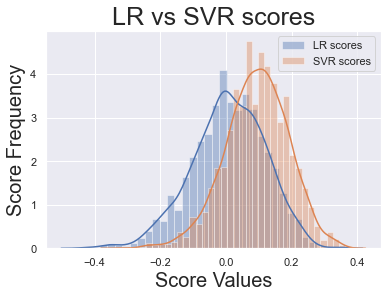

In [6]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('lr'),
    reg2=load_model('svr'),
    X=x_test.copy(),
    y=y_test.copy(),
    random_state_list = random_state_list
)


plot_score_dist(reg1_scores, reg2_scores, 'LR', 'SVR')

In [7]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

-0.22585518124292447
0.21120015836753525
-0.10720190752061809
0.26963445389816926


## Linear Regression VS XGBoost

In [8]:
five_two(
    reg1=load_model('lr'),
    reg2=load_model('xgboost'),
    X=x_train.copy(),
    y=y_train.copy(),
    metric='default'
    )

[08:41:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/gbm/gbtree.cc:82: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
Fold  1 score difference = 0.006751
[08:41:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/gbm/gbtree.cc:82: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
Fold  2 score difference = -0.182312
[08:41:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/gbm/gbtree.cc:82: DANGER AHEAD: You have

mean_score_1 0.007431659662064435, std 0.11207138213833909
mean_score_2 0.2560525209469454, std 0.06342084276705828
Ttest_relResult(statistic=-135.91431575027656, pvalue=0.0)
P value menor ou igual a 0.05


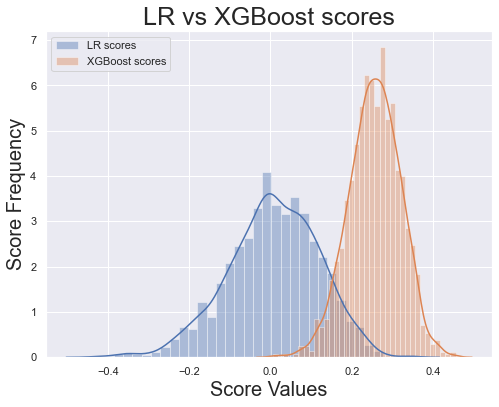

In [9]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('lr'),
    reg2=load_model('xgboost'),
    X=x_test.copy(),
    y=y_test.copy(),
    random_state_list = random_state_list
)

plot_score_dist(reg1_scores, reg2_scores, 'LR', 'XGBoost')

In [10]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

-0.22585518124292447
0.21120015836753525
0.1258826093734221
0.37124573466963745


# Linear Regression VS Neural Network

In [11]:
five_two(
    reg1=load_model('lr'),
    reg2=load_model('mlpRegressor'),
    X=x_train.copy(),
    y=y_train.copy(),
    metric='default'
    )

Fold  1 score difference = -0.022245
Fold  2 score difference = -0.136221
Fold  1 score difference = -0.103666
Fold  2 score difference = -0.125707
Fold  1 score difference = -0.164946
Fold  2 score difference = -0.046169
Fold  1 score difference = -0.030722
Fold  2 score difference = 0.018119
Fold  1 score difference = -0.198267
Fold  2 score difference = -0.087422
Regression 1 mean score and stdev : 0.044218 + 0.075158
Regression 2 mean score and stdev : 0.133942 + 0.054039
Score difference mean + stdev : -0.089725 + 0.065313
t_value for the current test is -0.342200


mean_score_1 0.09334871012535541, std 0.09651134460593469
mean_score_2 0.17469510681860037, std 0.07069702951039589
Ttest_relResult(statistic=-84.57787970327912, pvalue=0.0)
P value menor ou igual a 0.05


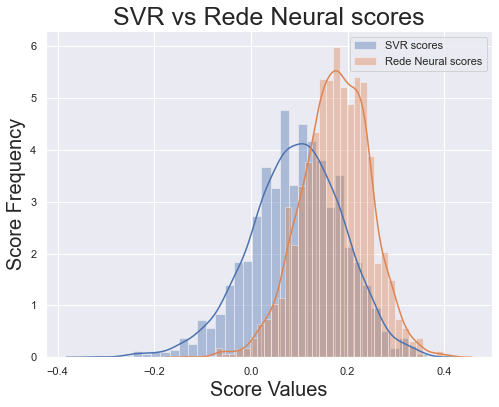

In [12]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('svr'),
    reg2=load_model('mlpRegressor'),
    X=x_test.copy(),
    y=y_test.copy(),
    random_state_list = random_state_list
)

plot_score_dist(reg1_scores, reg2_scores, 'SVR', 'Rede Neural')

In [13]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

-0.10720190752061809
0.26963445389816926
0.02764057261807578
0.3042777346277699


## SVR VS XGboost

In [14]:
five_two(
    reg1=load_model('svr'),
    reg2=load_model('xgboost'),
    X=x_train.copy(),
    y=y_train.copy(),
    metric='default'
    )

[08:42:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/gbm/gbtree.cc:82: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
Fold  1 score difference = 0.003417
[08:42:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/gbm/gbtree.cc:82: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
Fold  2 score difference = -0.050201
[08:42:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/gbm/gbtree.cc:82: DANGER AHEAD: You have

mean_score_1 0.09334871012535541, std 0.09651134460593469
mean_score_2 0.2560525209469454, std 0.06342084276705828
Ttest_relResult(statistic=-138.1952466909611, pvalue=0.0)
P value menor ou igual a 0.05


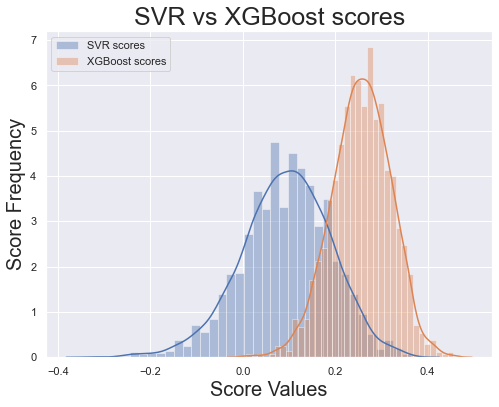

In [15]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('svr'),
    reg2=load_model('xgboost'),
    X=x_test.copy(),
    y=y_test.copy(),
    random_state_list = random_state_list
)

plot_score_dist(reg1_scores, reg2_scores, 'SVR', 'XGBoost')

In [16]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

-0.10720190752061809
0.26963445389816926
0.1258826093734221
0.37124573466963745


# SVR vs Neural Network

In [17]:
five_two(
    reg1=load_model('svr'),
    reg2=load_model('mlpRegressor'),
    X=x_train.copy(),
    y=y_train.copy(),
    metric='default'
    )

Fold  1 score difference = -0.024770
Fold  2 score difference = -0.000255
Fold  1 score difference = 0.001082
Fold  2 score difference = 0.106791
Fold  1 score difference = 0.046965
Fold  2 score difference = 0.043019
Fold  1 score difference = -0.004038
Fold  2 score difference = 0.034714
Fold  1 score difference = -0.029111
Fold  2 score difference = -0.008330
Regression 1 mean score and stdev : 0.155597 + 0.047330
Regression 2 mean score and stdev : 0.138990 + 0.041199
Score difference mean + stdev : 0.016607 + 0.039314
t_value for the current test is -0.668610


mean_score_1 0.09334871012535541, std 0.09651134460593469
mean_score_2 0.17469510681860037, std 0.07069702951039589
Ttest_relResult(statistic=-84.57787970327912, pvalue=0.0)
P value menor ou igual a 0.05


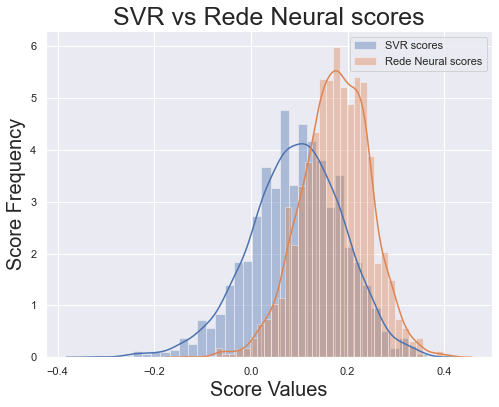

In [18]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('svr'),
    reg2=load_model('mlpRegressor'),
    X=x_test.copy(),
    y=y_test.copy(),
    random_state_list = random_state_list
)

plot_score_dist(reg1_scores, reg2_scores, 'SVR', 'Rede Neural')

In [19]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

-0.10720190752061809
0.26963445389816926
0.02764057261807578
0.3042777346277699


# XGBoost vs Neural Network

In [20]:
five_two(
    reg1=load_model('xgboost'),
    reg2=load_model('mlpRegressor'),
    X=x_train.copy(),
    y=y_train.copy(),
    metric='default'
    )

[08:43:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/gbm/gbtree.cc:82: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
Fold  1 score difference = -0.013473
[08:43:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/gbm/gbtree.cc:82: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
Fold  2 score difference = 0.047426
[08:43:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/gbm/gbtree.cc:82: DANGER AHEAD: You have

mean_score_1 0.2560525209469454, std 0.06342084276705828
mean_score_2 0.17469510681860037, std 0.07069702951039589
Ttest_relResult(statistic=99.37024854130769, pvalue=0.0)
P value menor ou igual a 0.05


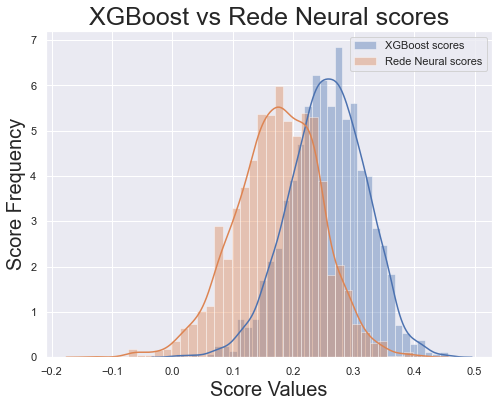

In [21]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('xgboost'),
    reg2=load_model('mlpRegressor'),
    X=x_test.copy(),
    y=y_test.copy(),
    random_state_list = random_state_list
)

plot_score_dist(reg1_scores, reg2_scores, 'XGBoost', 'Rede Neural')

In [22]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

0.1258826093734221
0.37124573466963745
0.02764057261807578
0.3042777346277699
